# UCE

UCE is a large transformer model for generating cell embeddings. The model was trained on a corpus of cell atlas data from human and seven other species in a completely self-supervised manner without any data annotations. UCE takes a sample of the genes that a cell expressed, weighted by their expression and with replacement. Genes are tokenized using the ESM2 protein language model, allowing cross species and new species embedding.

Here, you can use `omicverse.llm.SCLLMManager(model_type="uce")` to call this model directly.

Cite: Rosen, Y., Roohani, Y., Agarwal, A., Samotorčan, L., Tabula Sapiens Consortium, Quake, S. R., & Leskovec, J. (2023). Universal cell embeddings: A foundation model for cell biology. bioRxiv, 2023-11.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Download UCE model files

UCE requires several specialized files that incorporate evolutionary and genomic information. The model architecture combines traditional expression data with protein sequence embeddings and genomic context to create robust cell representations.

**Required UCE components:**
- **Model checkpoints**: Pre-trained transformer weights (4layer_model.torch, 33l_8ep_1024t_1280.torch)
- **Token embeddings**: Gene tokenization matrix (all_tokens.torch) 
- **Protein embeddings**: ESM2-derived protein sequence embeddings for multiple species
- **Genomic mappings**: Species-specific chromosome and gene location information
- **Species offsets**: Coordinate systems for multi-species gene mapping

**Multi-species support:**
The protein embeddings directory contains ESM2-based representations for:
- Homo sapiens (human)
- Mus musculus (mouse)  
- Macaca fascicularis (macaque)
- Danio rerio (zebrafish)
- Sus scrofa (pig)
- And other model organisms

This evolutionary foundation enables UCE to work effectively across species and transfer knowledge between related organisms.

In [2]:
#!/usr/bin/env python3
import os
import requests
from tqdm import tqdm


output_dir = "llm_model/models/UCE"
os.makedirs(output_dir, exist_ok=True)

files_to_download = {
    "species_chrom.csv":         "https://figshare.com/ndownloader/files/42706558",
    "species_offsets.pkl":       "https://figshare.com/ndownloader/files/42706555",
    "all_tokens.torch":          "https://figshare.com/ndownloader/files/42706585",
    "4layer_model.torch":        "https://figshare.com/ndownloader/files/42706576",
    "33l_8ep_1024t_1280.torch":  "https://figshare.com/ndownloader/files/43423236",
    "protein_embeddings.tar.gz": "https://figshare.com/ndownloader/files/42715213",
}

for filename, url in files_to_download.items():
    filepath = os.path.join(output_dir, filename)
    
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total = int(resp.headers.get('content-length', 0))
    
    
    with open(filepath, "wb") as f, tqdm(
        desc=f"Downloading {filename}",
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))
    print(f"Saved to {filepath}")



Saved to llm_model/models/UCE/species_chrom.csv


Saved to llm_model/models/UCE/species_offsets.pkl


Saved to llm_model/models/UCE/all_tokens.torch


Saved to llm_model/models/UCE/4layer_model.torch


Saved to llm_model/models/UCE/33l_8ep_1024t_1280.torch


Saved to llm_model/models/UCE/protein_embeddings.tar.gz
所有文件下载完成。


In [3]:
import tarfile

archive_path = "llm_model/models/UCE/protein_embeddings.tar.gz"
extract_dir = "llm_model/models/UCE"

with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print(f" {archive_path} unzip to {extract_dir}")


 llm_model/models/UCE/protein_embeddings.tar.gz unzip to llm_model/models/UCE


In [16]:
!ls llm_model/models/UCE/protein_embeddings/

Danio_rerio.GRCz11.gene_symbol_to_embedding_ESM2.pt
Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt
Macaca_fascicularis.Macaca_fascicularis_6.0.gene_symbol_to_embedding_ESM2.pt
Macaca_mulatta.Mmul_10.gene_symbol_to_embedding_ESM2.pt
Microcebus_murinus.Mmur_3.0.gene_symbol_to_embedding_ESM2.pt
Mus_musculus.GRCm39.gene_symbol_to_embedding_ESM2.pt
Sus_scrofa.Sscrofa11.1.gene_symbol_to_embedding_ESM2.pt
Xenopus_tropicalis.Xenopus_tropicalis_v9.1.gene_symbol_to_embedding_ESM2.pt


## Initialize UCE model

UCE initialization requires careful configuration of multiple components that enable its evolutionary-informed analysis capabilities. The model setup involves loading pre-trained weights, protein embeddings, and species-specific mappings.


In [2]:
manager = ov.llm.SCLLMManager(
    model_type="uce",
    model_path="llm_model/models/UCE/4layer_model.torch",
    token_file='llm_model/models/UCE/all_tokens.torch',
    protein_embeddings_dir='llm_model/models/UCE/protein_embeddings/',
    spec_chrom_csv_path='llm_model/models/UCE/species_chrom.csv',
    offset_pkl_path='llm_model/models/UCE/species_offsets.pkl',
    species='human',
    device='cuda'
)

[Loaded] UCE model initialized
[Loading] Loading UCE model and assets
[Loading] === UCE Asset Files Validation ===
[Loaded] ✓ Model weights: llm_model/models/UCE/4layer_model.torch
[Loaded] ✓ Token embeddings: llm_model/models/UCE/all_tokens.torch
[Loaded] ✓ Species chromosome mapping: llm_model/models/UCE/species_chrom.csv
[Loaded] ✓ Species offsets: llm_model/models/UCE/species_offsets.pkl
[Loaded] ✓ Protein embeddings directory: llm_model/models/UCE/protein_embeddings
[Loaded] ✓ Found protein embedding: Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt
[Loaded] ✓ Found protein embedding: Mus_musculus.GRCm39.gene_symbol_to_embedding_ESM2.pt
[Loading] === UCE Configuration ===
[Loaded] • Species: human
[Loaded] • Batch size: 25
[Loaded] • Model layers: 4
[Loaded] • Output dimension: 1280
[Loaded] • Token dimension: 5120
[Loaded] • Hidden dimension: 5120
[Loading] === UCE Configuration ===
[Loaded] ✓ Protein embeddings directory: llm_model/models/UCE/protein_embeddings
[Loaded] ✓ Fo

## Load example datasets

For this tutorial, we use three batches from the NeurIPS 2021 single-cell competition dataset, which provides an excellent test case for batch integration and cell type annotation.

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [3]:
adata1=ov.read('data/llm_test/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/llm_test/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/llm_test/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [4]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None,target_sum=1e4)
adata

Begin robust gene identification
After filtration, 13953/13953 genes are kept.     Among 13953 genes, 13953 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'HBB', 'MALAT1', 'IGHA1', 'IGHM', 'HBA2', 'IGLC1', 'IGLC2', 'IGLC3']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 3.410970449447632 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Zero-shot embedding generation

Zero-shot analysis with UCE leverages evolutionary knowledge and multi-species training to generate meaningful cell representations without dataset-specific training.

The resulting embeddings combine transcriptional information with evolutionary context, creating representations 1280 that are both biologically meaningful and technically robust.

In [7]:
embeddings = manager.get_embeddings(
    adata,filter_cells=False,filter_genes=False
)
print(f"embedding: {embeddings.shape}")

adata.obsm['X_uce'] = embeddings

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[Embedding] Extracting cell embeddings using UCE
[Embedding] Processing data in memory
[Embedding] UCE model loaded and ready for inference
[Embedding] Creating UCE dataset in memory


UCE inference:   0%|          | 0/1097 [00:00<?, ?it/s]

[Embedding] Extracted embeddings: (27423, 1280)
embedding: (27423, 1280)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


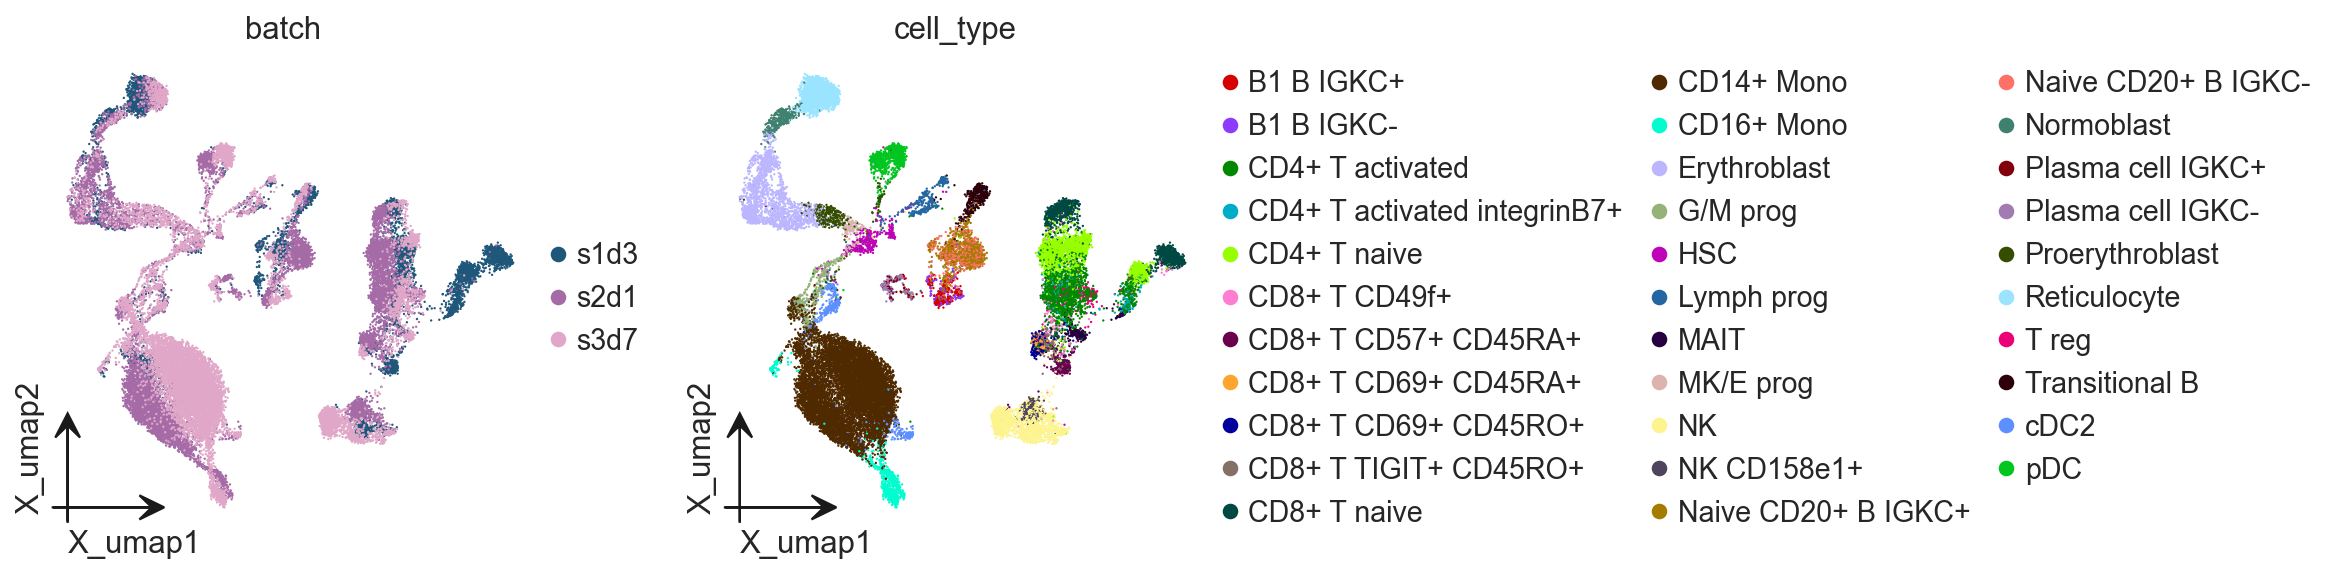

In [8]:
sc.pp.neighbors(adata, use_rep='X_uce')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


🔗 Performing batch integration for 27423 cells
Extracting embeddings for integration
[Embedding] Extracting cell embeddings using UCE
[Embedding] Processing data in memory
[Embedding] UCE model loaded and ready for inference
[Embedding] Creating UCE dataset in memory


UCE inference:   0%|          | 0/1097 [00:00<?, ?it/s]

[Embedding] Extracted embeddings: (27423, 1280)


Batch integration:   0%|                                                      | 0/2 [00:00<?, ?it/s]

Applying MNN correction
MNN correction applied to 3 batches
Integration completed with mnn correction
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)


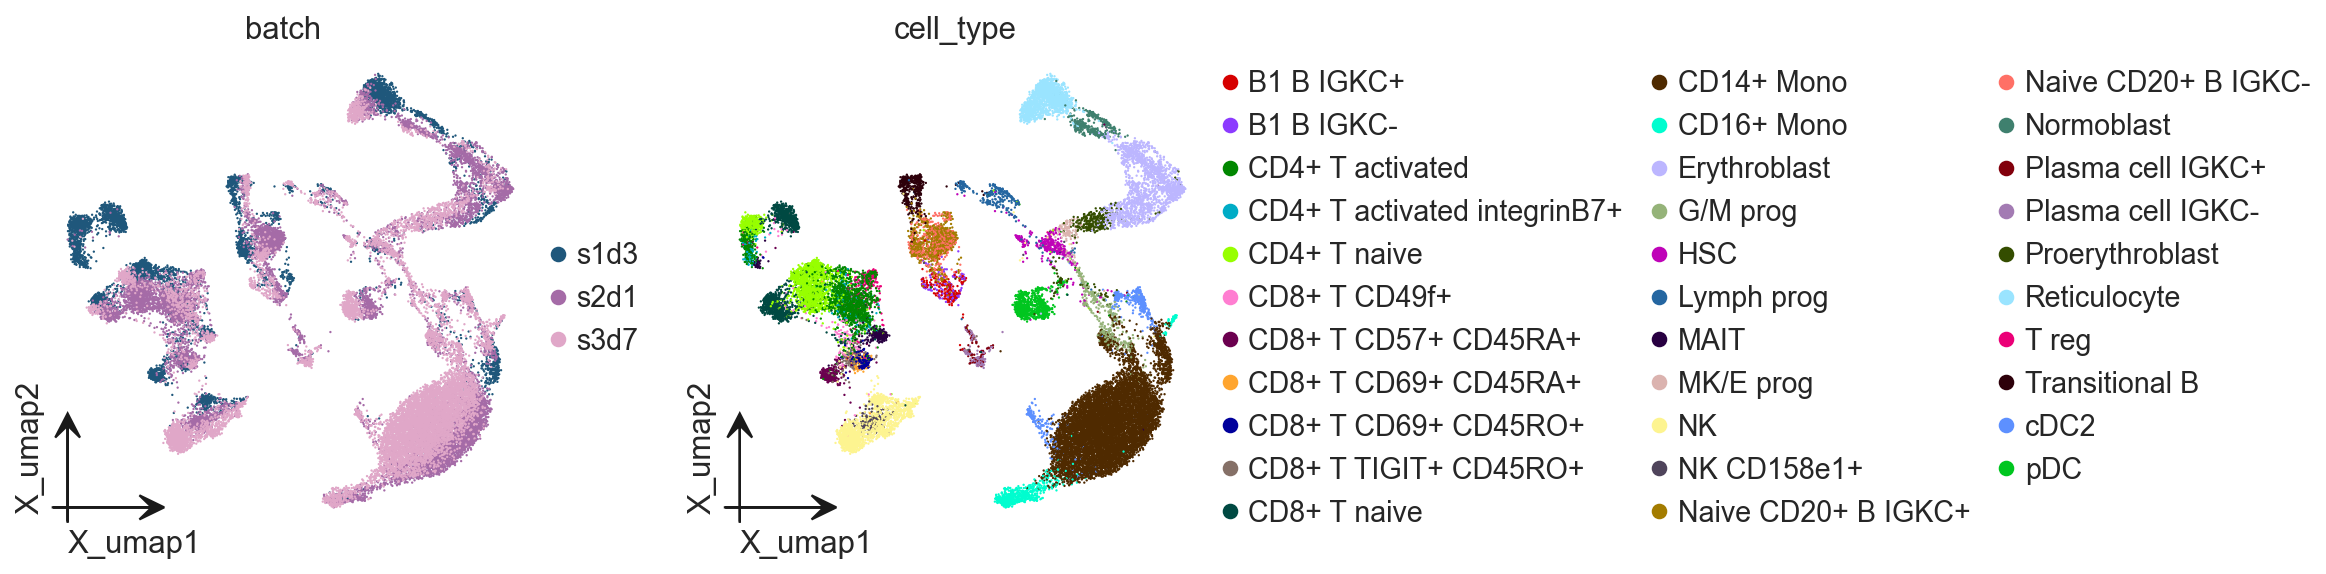

In [9]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
)
adata.obsm['X_uce_mnn'] = zero_shot_results['embeddings']
sc.pp.neighbors(adata, use_rep='X_uce_mnn')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

## Fine-tuning with linear probing

UCE supports two fine-tuning approaches: linear probing and end-to-end training. Linear probing provides an efficient way to adapt UCE to specific datasets while preserving the rich evolutionary representations learned during pre-training.

**Linear probing methodology:**
- **Frozen backbone**: UCE transformer weights remain fixed, preserving evolutionary knowledge
- **Trainable classifier**: Only the classification head is updated for the specific task
- **Efficiency**: Faster training with lower computational requirements
- **Stability**: Reduced risk of overfitting on limited training data
- **Interpretability**: Changes in performance directly reflect classification head adaptation

In [10]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [11]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [15]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=10,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
    freeze_backbone=True 
)

[Fine-tuning] 🎯 Starting UCE linear probing fine-tuning for cell type annotation
[ℹ️Info] Found 30 cell types
[Preprocessing] Preprocessing data for UCE


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[Preprocessing] Preprocessed data: 5935 cells × 13953 genes
[Preprocessing] Pre-computing UCE embeddings for linear probing...
[Embedding] Extracting cell embeddings using UCE
[Embedding] Processing data in memory
[Embedding] UCE model loaded and ready for inference
[Embedding] Creating UCE dataset in memory


UCE inference:   0%|          | 0/238 [00:00<?, ?it/s]

[Embedding] Extracted embeddings: (5935, 1280)
[Preprocessing] Pre-computed embeddings: train=(5935, 1280)
[Training] Starting linear probing training for 10 epochs


Linear Probing:   0%|          | 0/10 [00:00<?]

[Fine-tuning] ✅ UCE fine-tuning completed successfully


### integrated

In [25]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
)
adata.obsm['X_uce_fine'] = zero_shot_results['embeddings']

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


🔗🎯 Performing batch integration using fine-tuned UCE for 27423 cells
Extracting embeddings for integration
Using original UCE model for integration (backbone frozen)
[Embedding] Processing data in memory
[Embedding] UCE model loaded and ready for inference
[Embedding] Creating UCE dataset in memory


UCE inference:   0%|          | 0/1097 [00:00<?, ?it/s]

Batch integration:   0%|                                                      | 0/2 [00:00<?, ?it/s]

Applying MNN correction
MNN correction applied to 3 batches
Integration completed with mnn correction


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)


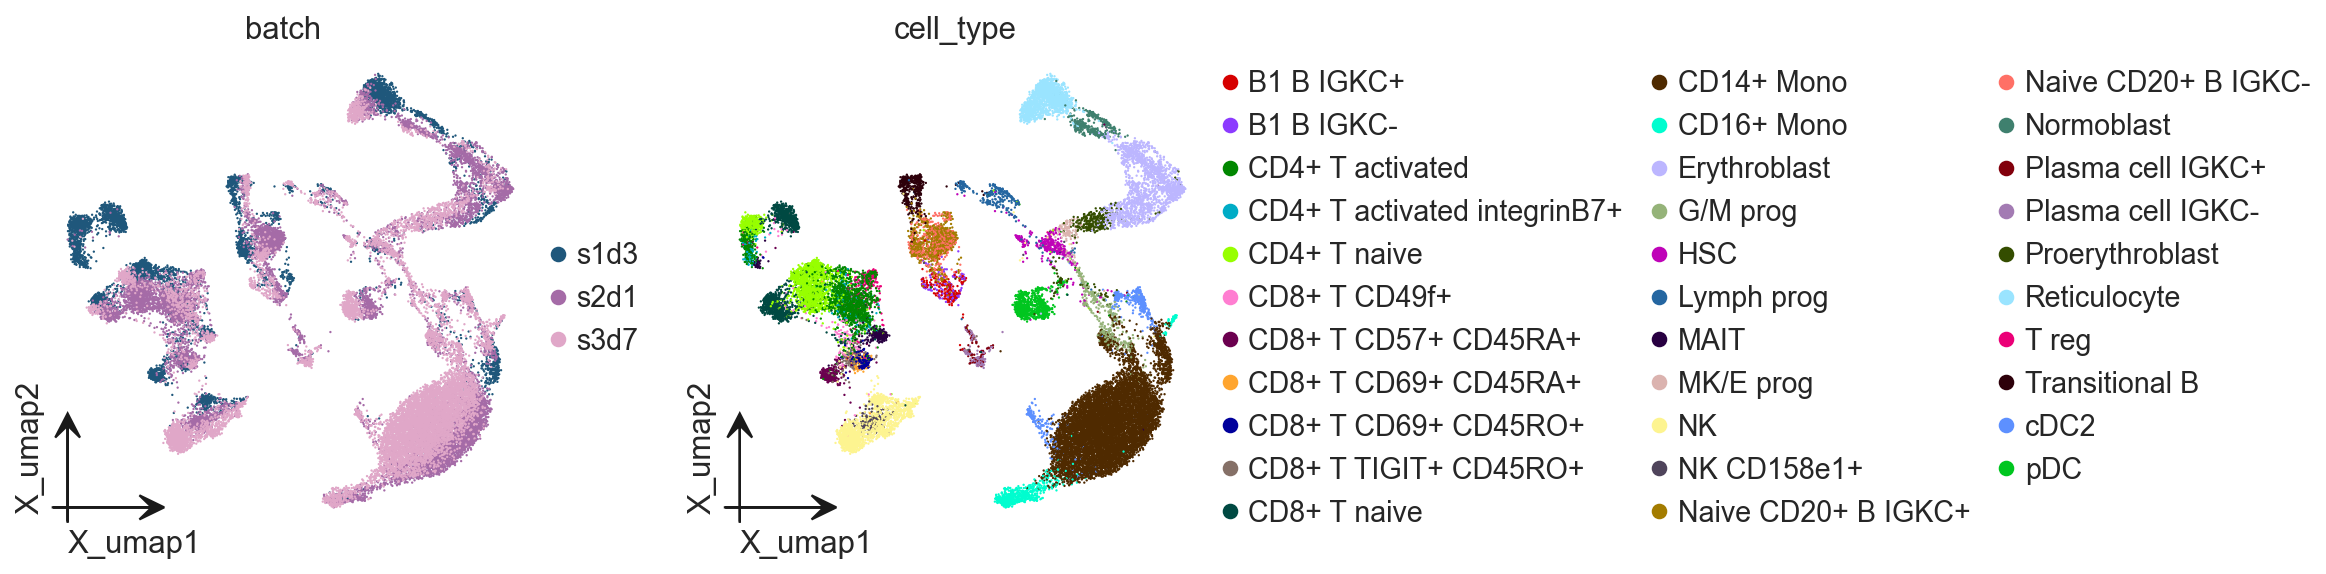

In [26]:
sc.pp.neighbors(adata, use_rep='X_uce_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### annotation

In [21]:
prediction_results = manager.model.predict(
    adata,
    task='annotation',
)

#adata.obs['predicted_celltype'] = prediction_results['predicted_celltypes']
adata.obs['predicted_celltype'] = prediction_results['predictions']

[Predicting] Predicting cell types using fine-tuned UCE model
[Preprocessing] Preprocessing data for UCE


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[Preprocessing] Preprocessed data: 27423 cells × 13953 genes
[Predicting] Using linear probing model for prediction
[Embedding] Computing embeddings for linear probing prediction...
[Embedding] Using original UCE model for embeddings (backbone frozen)
[Embedding] Processing data in memory
[Embedding] UCE model loaded and ready for inference
[Embedding] Creating UCE dataset in memory


UCE inference:   0%|          | 0/1097 [00:00<?, ?it/s]

[Embedding] Generated embeddings: (27423, 1280)
[Predicting] Predicted cell types for 27423 cells


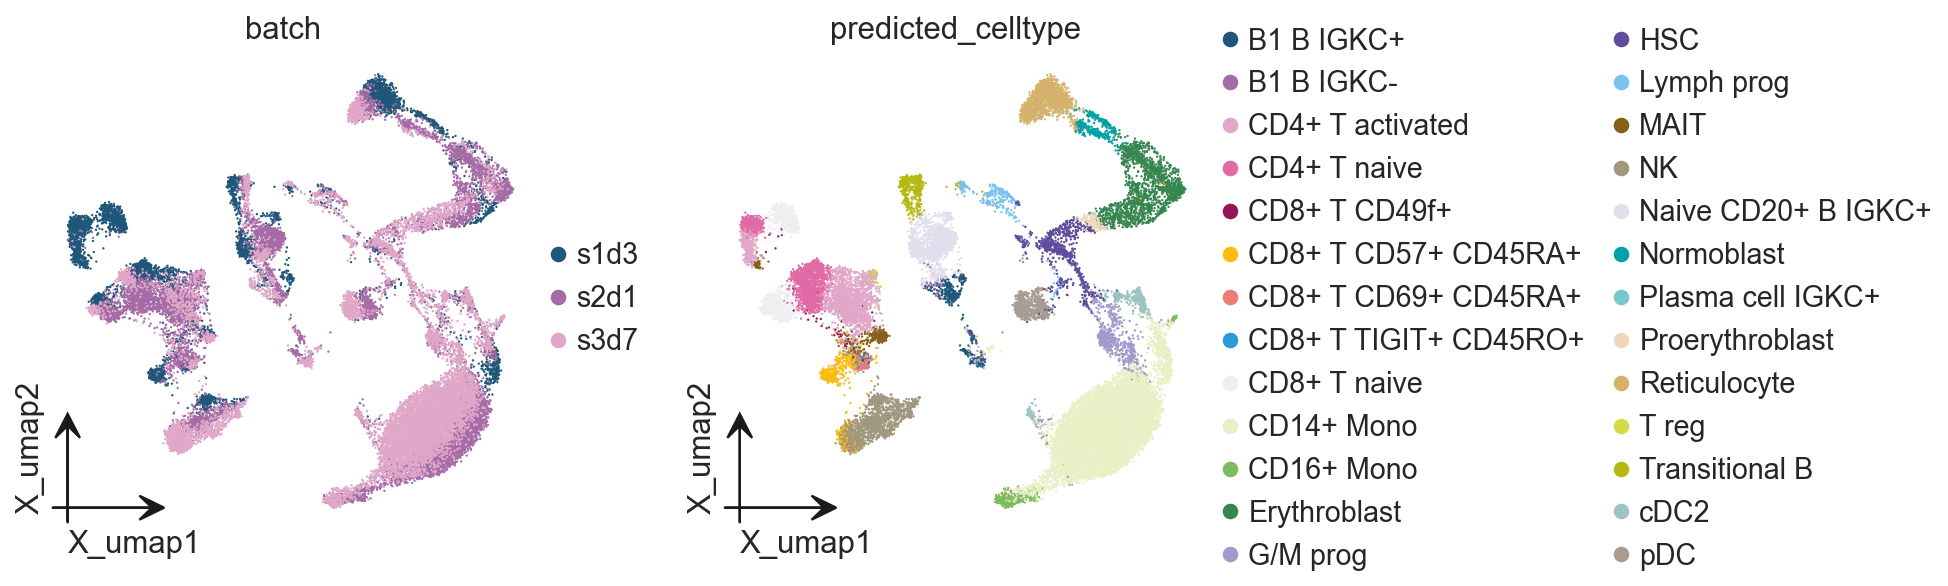

In [22]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)

## Fine-tuning End-to-end for maximum performance

End-to-end fine-tuning represents the most comprehensive adaptation approach, where both the UCE transformer backbone and classification head are updated to optimize performance on the specific dataset.

**End-to-end methodology:**
- **Unfrozen backbone**: All UCE transformer weights can be updated during training
- **Full model adaptation**: Both feature extraction and classification are optimized together
- **Maximum performance**: Potentially highest accuracy through complete model adaptation
- **Dataset specialization**: Model becomes highly specialized for the specific task and data distribution


In [8]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [9]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [10]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=10,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
    freeze_backbone=False 
)

[Fine-tuning] 🎯 Starting UCE end-to-end fine-tuning for cell type annotation
[ℹ️Info] Found 30 cell types
[ℹ️Info] UCE backbone unfrozen - end-to-end fine-tuning mode
[Preprocessing] Preprocessing data for UCE
[Preprocessing] Preprocessed data: 5935 cells × 13953 genes
[Preprocessing] Preparing UCE raw data for end-to-end training...
[Warning] Warning: 2155 genes not found in UCE protein embeddings
[Warning] First 10 missing genes: ['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'MRPL20-AS1', 'AL645728.1', 'AL691432.2', 'FO704657.1', 'SLC35E2A']...
[Warning] Filtered data to 11798 valid genes
[Preprocessing] Raw UCE data prepared: (5935, 11798)
[Fine-tuning] 🎯 Epoch 1/20 completed - Loss: 2.3958, Acc: 0.4711
[Fine-tuning] 🎯 Epoch 2/20 completed - Loss: 1.1964, Acc: 0.6755
[Fine-tuning] 🎯 Epoch 3/20 completed - Loss: 0.9449, Acc: 0.7154
[Fine-tuning] 🎯 Epoch 4/20 completed - Loss: 0.7901, Acc: 0.7515
[Fine-tuning] 🎯 Epoch 5/20 completed - Loss: 0.7352, Acc: 0.7636
[Fine-

### integrate

In [11]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
)
adata.obsm['X_uce_fine'] = zero_shot_results['embeddings']

🔗🎯 Performing batch integration using fine-tuned UCE for 27423 cells
Extracting embeddings for integration
[Embedding] 🎯 Extracting embeddings using fine-tuned UCE model
[Preprocessing] Preprocessing data for UCE
[Preprocessing] Preprocessed data: 27423 cells × 13953 genes
[Preprocessing] Preparing UCE raw data for end-to-end training...
[Warning] Warning: 2155 genes not found in UCE protein embeddings
[Warning] First 10 missing genes: ['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'MRPL20-AS1', 'AL645728.1', 'AL691432.2', 'FO704657.1', 'SLC35E2A']...
[Warning] Filtered data to 11798 valid genes
[Preprocessing] Raw UCE data prepared: (27423, 11798)
[Embedding] Extracted embeddings from fine-tuned UCE: (27423, 1280)


Batch integration:   0%|                                                      | 0/2 [00:00<?, ?it/s]

Applying MNN correction
MNN correction applied to 3 batches
Integration completed with mnn correction


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


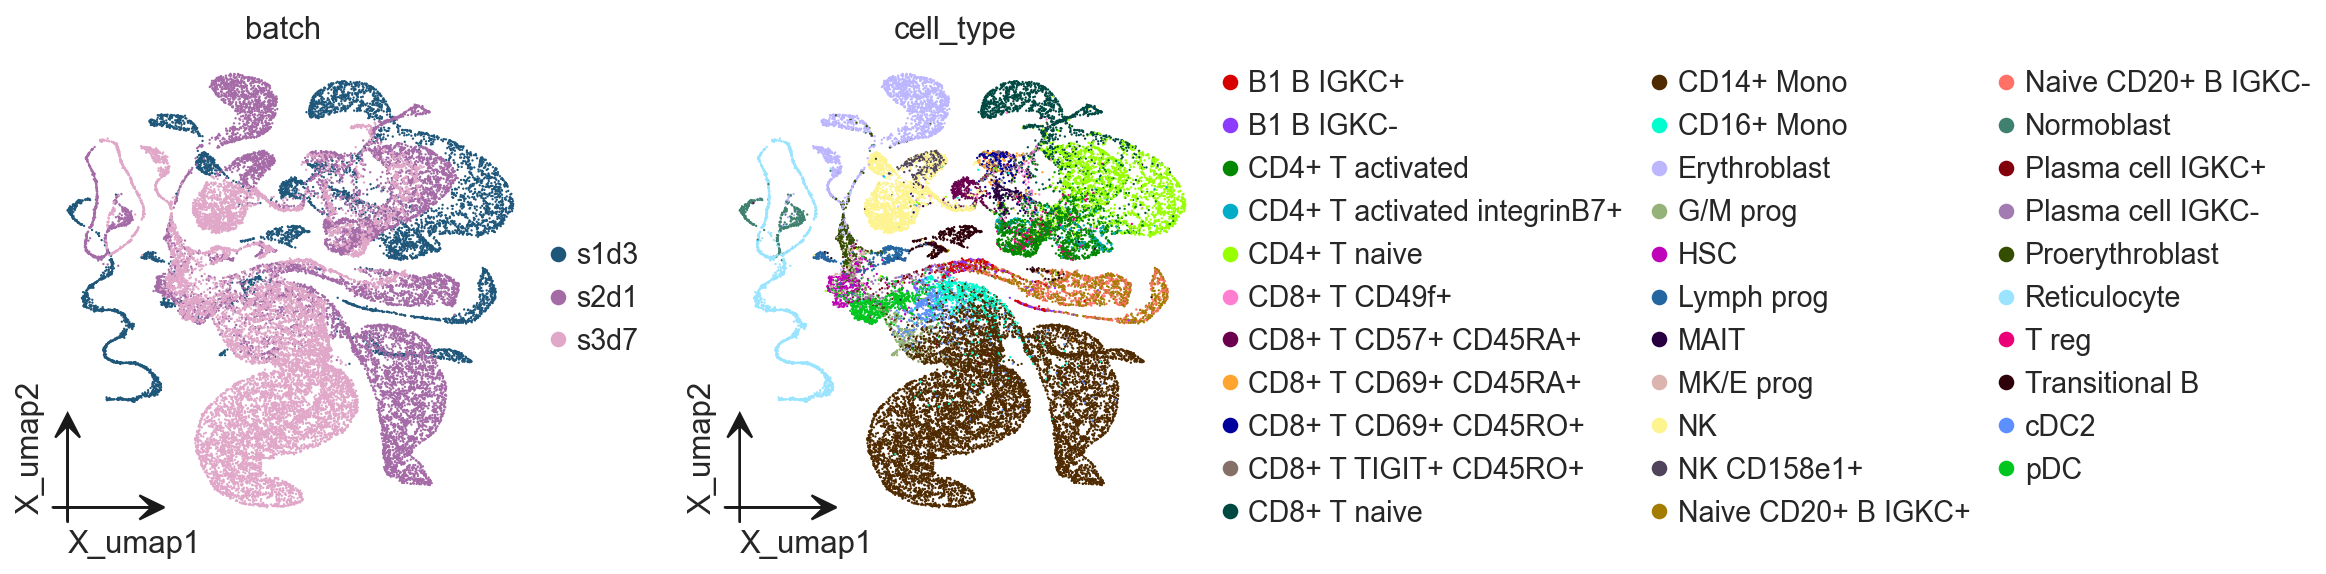

In [12]:
sc.pp.neighbors(adata, use_rep='X_uce_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### annotation

In [13]:
prediction_results = manager.model.predict(
    adata,
    task='annotation',
)

#adata.obs['predicted_celltype'] = prediction_results['predicted_celltypes']
adata.obs['predicted_celltype'] = prediction_results['predictions']

[Predicting] Predicting cell types using fine-tuned UCE model
[Preprocessing] Preprocessing data for UCE
[Preprocessing] Preprocessed data: 27423 cells × 13953 genes
[Preprocessing] Preparing UCE raw data for end-to-end training...
[Warning] Warning: 2155 genes not found in UCE protein embeddings
[Warning] First 10 missing genes: ['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'MRPL20-AS1', 'AL645728.1', 'AL691432.2', 'FO704657.1', 'SLC35E2A']...
[Warning] Filtered data to 11798 valid genes
[Preprocessing] Raw UCE data prepared: (27423, 11798)
[Predicting] Predicted cell types for 27423 cells


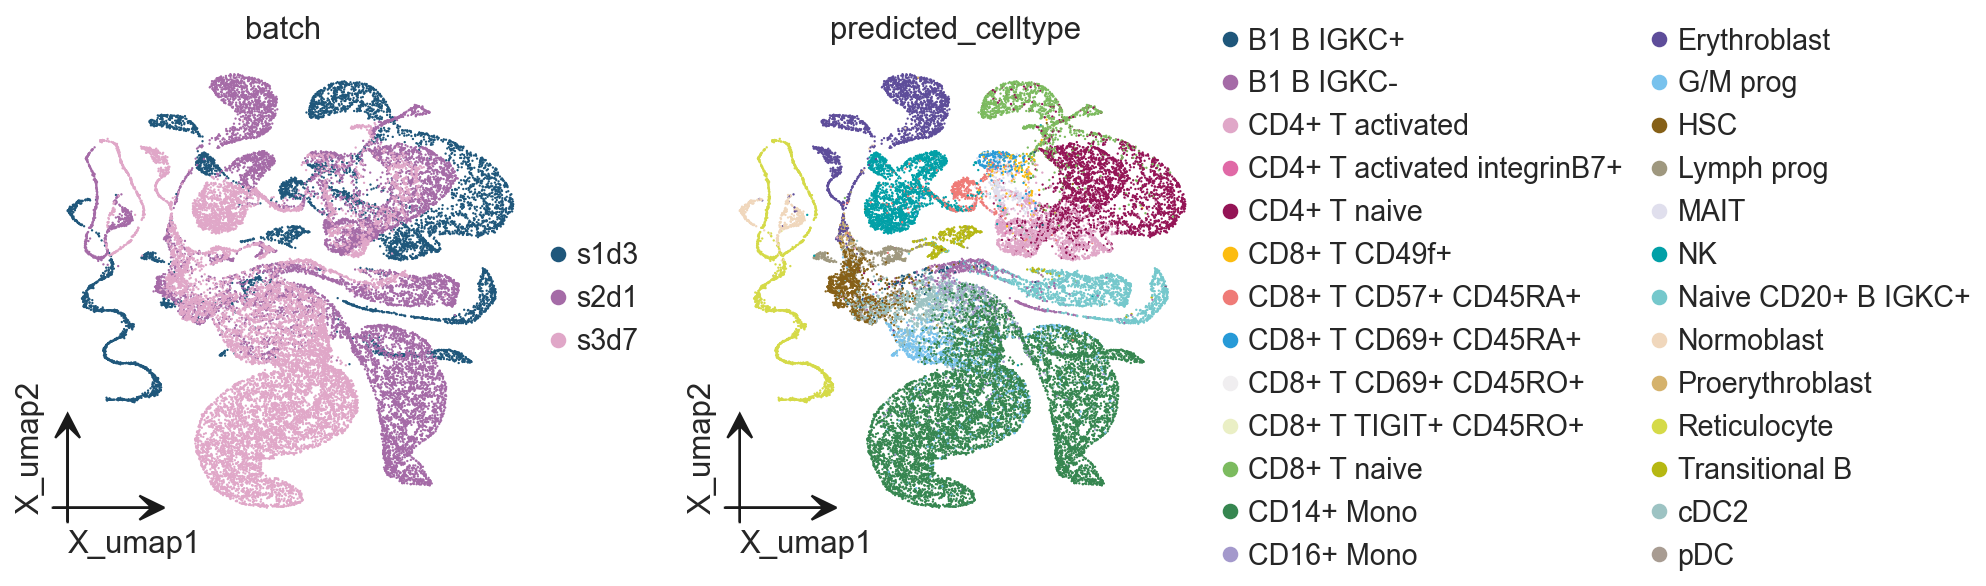

In [14]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)